# Boot Data

In [1]:
P_G_S = " Transportation "
z = 5
epochs = 5000

In [2]:
column = ["01","02","03","04","05","06","07","08","09","10","11","12"]
row = ["All-items","Food","Shelter",
       "Household operations, furnishings and equipment",
       "Clothing and footwear","Transportation","Health and personal care",
       "Recreation, education and reading",
       "Alcoholic beverages, tobacco products and recreational cannabis",
       "All-items excluding food","All-items excluding food and energy"]

## Run of the packages

In [3]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from math import log
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Run the database

In [4]:
MAPI_N_18_21 = pd.read_csv("MAPI_N_18_21.cvs")
#MAPI_N_18_21.head()

In [5]:
df = MAPI_N_18_21[["year","month","REF_DATE","Products and product groups","COORDINATE","VALUE"]]
#df.tail()

## Add pandemic variables

In [6]:
df["pandemic"] = 1

In [7]:
for i in np.arange(len(df)):
  if (df["year"][i] < 2020):
    df["pandemic"][i]=0
df["pandemic"][((df["year"] == 2020) & (df["month"] == 1))] = 0

## Preparation for the model. This is where you specify what "goods or service" you want to project.

In [8]:
rm = df[(df["Products and product groups"] == row[z])]
rm['Data'] = np.arange(len(rm))
#rm.head()

In [9]:
rm.index = np.arange(len(rm))

In [10]:
rm["pa_col"] = 1

In [11]:
for i in np.arange(len(rm)):
  if (rm["pandemic"][i] == 1):
    rm["pa_col"][i] = "red"
  else:
    rm["pa_col"][i] = "green"

## Regression model

In [12]:
# Correlación lineal entre las dos variables
# ==============================================================================
corr_test = pearsonr(x = rm.Data, y = rm.VALUE)
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  0.7344264690158194
P-value:  1.3927239846278462e-08


In [13]:
# División de los datos en train y test
# ==============================================================================
X = rm[['Data']]
y = rm.VALUE

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación del modelo
# ==============================================================================
modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
# Información del modelo
# ==============================================================================
print("Intercept:", modelo.intercept_)
print("Coeficiente:", list(zip(X.columns, modelo.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", modelo.score(X, y))

Intercept: [100.09090115]
Coeficiente: [('Data', 0.17261866355511662)]
Coeficiente de determinación R^2: 0.5376982196983807


In [15]:
Intercepto = modelo.intercept_
Coeficiente = modelo.coef_.flatten()

In [16]:
# Error de test del modelo 
# ==============================================================================
predicciones = modelo.predict(X = X_test)
print(predicciones[0:3,])

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")

[[105.0968424 ]
 [103.02541844]
 [105.78731705]]

El error (rmse) de test es: 1.7376194847834854


## Adjustment

In [17]:
A = np.array(Intercepto+Coeficiente*rm.Data)

In [18]:
rm['Pred_r'] = A
#.head()

### Adjustment (CM)

In [19]:
rm['CM'] = rm['VALUE'] - rm['Pred_r']

### Adjustment 1 (CM1)

In [20]:
rm["CM1"] = rm.CM - rm.CM.mean()

### Adjustment 2 (CM2)

In [21]:
rm["CM2"]=rm.CM1-2*rm.CM1.min()

## Process graph (with measurement change)

In [22]:
M = np.repeat(-2*rm.CM1.min(), len(rm.Data), axis=0)
M = M.astype(np.float64)

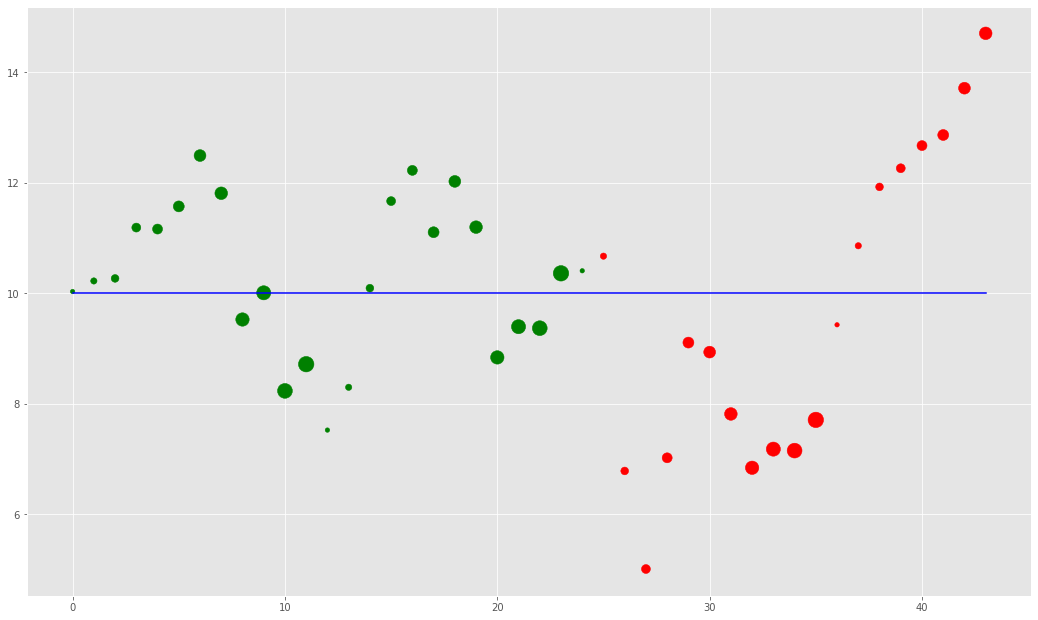

In [23]:
fig, ax = plt.subplots(figsize=(18, 10.84))

ax.scatter(x=rm.Data,y=rm.CM2, s=rm.month*20, marker='o', color = np.array(rm["pa_col"]))
ax.plot(rm.Data, M, linestyle='-', color='blue')

## Model

### Function to reduce times

In [24]:
def MC (Dato, Obs, opc, Esp, Var) :
  if (opc==1):
    y= Esp + (Dato - Esp)/Obs #Esperanza
  else:
    if (Obs>1):
      y= (Obs - 1)/Obs*Var + (Dato-Esp)**2/Obs - 2*(Dato-Esp)/(Obs*(Obs - 1)) + ((Dato-Esp)/(Obs-1))**2 #Varianza
    else:
      y=0
  return y

### Occupy CM2, here is i_F

In [25]:
#-----i_F = es el interes creado bajo la filtracion-----#
g = rm.CM2
n = len(g)-1

rm["i_F"] = np.array(np.arange(n+1))
rm["i_F"] = rm["i_F"].values.astype(np.float64)

for i in np.arange(n):
  rm["i_F"][i+1]=g[i+1]/g[i]-1

i_F = rm["i_F"]
i_F=rm["i_F"].drop(rm["i_F"].index[0])

E_i=i_F.mean()
V_i=i_F.var()

### Regression to the mean model

In [26]:
t=16
dt=16/48
T=t/dt

R = np.repeat(0, epochs, axis=0)
R = R.astype(np.float64)

i_f = np.repeat(0, epochs, axis=0)
i_f = i_f.astype(np.float64)

P = np.repeat(0, epochs, axis=0)
P = P.astype(np.float64)

G = np.repeat(0, t, axis=0)
G = G.astype(np.float64)
G[0] = i_F[1]
G_s = np.repeat(0, t, axis=0)
G_s = G_s.astype(np.float64)
#D = np.arange(0, t, step = dt)

for i in np.arange(epochs):
  V_f=V_i
  E_f=E_i
  r_f= 1
  i_t1 = 0
  i_t2 = 0
  I_F=i_F
  for j in np.arange(T):
    W_t=np.random.normal(0, 1, 1)
    i_t3 = i_t2
    i_t2 = i_t1
    i_t1 = ( i_t2 - E_f + V_f/2 - math.sqrt(V_f/dt) * W_t ) * dt
    r = math.exp(i_t1)
    r_f = r_f * r

    #i_t = i_t1 - i_t2
    #js=(j+1).astype(np.int64)
    #V_f=MC(i_t, (n + js/2), 2, E_f, V_f)
    #E_f=MC(i_t, (n + js/2), 1, E_f, 0)

    if ((j+1)%3==0):
      i_t = i_t1 + i_t2 + i_t3
      js=(j+1).astype(np.int64)
      V_f=MC(i_t, (n + js/3), 2, E_f, V_f)
      E_f=MC(i_t, (n + js/3), 1, E_f, 0)

      js=(js/3-1).astype(np.int64)
      G[js]= G[js] + (i_t - G[js])/(i+1)
      if (i==(epochs-1)):
        G_s[js]= i_t
      
    
  R[i]= r_f
  i_f[i]= log(r_f)
  P[i]= g[len(g)-1] * r_f

## Adjustment 3 (G1-PPP y G2-PPP)

In [27]:
G1=G-G.mean()

In [28]:
PPP = np.repeat(0, len(G1), axis=0)
PPP = PPP.astype(np.float64)
PPP[0]=rm.CM2[len(rm.CM2)-1]*math.exp(G1[0])
for i in np.arange(len(G1)-1):
  PPP[i+1]=PPP[i]*math.exp(G1[i+1])

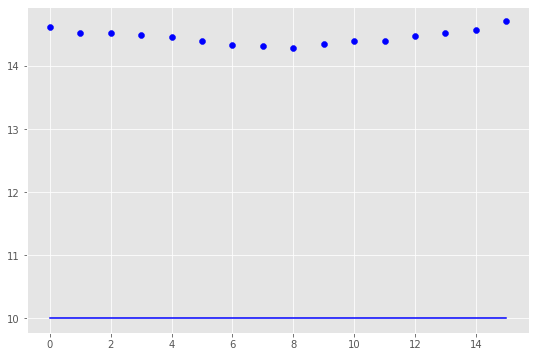

In [29]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.scatter(x=np.arange(len(PPP)),y=PPP, marker='o', color = "blue")
ax.plot(np.arange(len(PPP)), M[0:len(PPP)], linestyle='-', color='blue')

In [30]:
PV1=PPP

In [31]:
G2 = G_s - G_s.mean()

In [32]:
PPP = np.repeat(0, len(G2), axis=0)
PPP = PPP.astype(np.float64)
PPP[0]=rm.CM2[len(rm.CM2)-1]*math.exp(G2[0])
for i in np.arange(len(G2)-1):
  PPP[i+1]=PPP[i]*math.exp(G2[i+1])

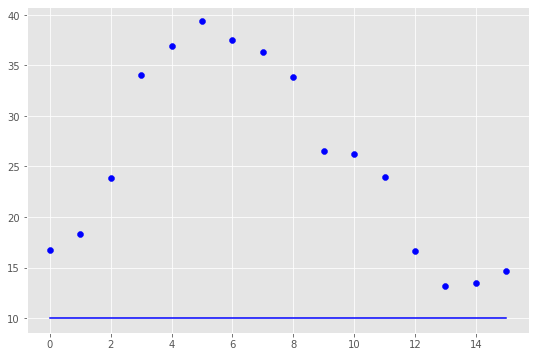

In [33]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.scatter(x=np.arange(len(PPP)),y=PPP, marker='o', color = "blue")
ax.plot(np.arange(len(PPP)), M[0:len(PPP)], linestyle='-', color='blue')

In [34]:
PV2=PPP

## Return changes and delivery chart

In [35]:
N_rm=rm[0:16]
N_rm=N_rm.drop(['i_F'], axis=1)
N_rm['Data'] = list(range(len(rm),len(rm)+16,1))
N_rm['pa_col'] = "blue"
N_rm['Pred_r'] = np.array(Intercepto+Coeficiente*N_rm.Data)
N_rm['pandemic'] = np.repeat(1, len(N_rm), axis=0)
N_rm.REF_DATE = pd.to_datetime([
              '2021-09-28',
              '2021-10-28',
              '2021-11-28',
              '2021-12-28',
              '2022-01-28',
              '2022-02-28',
              '2022-03-28',
              '2022-04-28',
              '2022-05-28',
              '2022-06-28',
              '2022-07-28',
              '2022-08-28',
              '2022-09-28',
              '2022-10-28',
              '2022-11-28',
              '2022-12-28'])
N_rm['year'] = N_rm['REF_DATE'].dt.year
N_rm['month'] = N_rm['REF_DATE'].dt.month
#N_rm.head()

In [36]:
PV1=PV1+2*rm.CM1.min()+N_rm['Pred_r']
PV2=PV2+2*rm.CM1.min()+N_rm['Pred_r']

In [37]:
N_rm.VALUE = PV1
rm2 = rm
rm2=rm2.drop(['i_F'], axis=1)
rm2 = pd.concat([rm2, N_rm])

In [38]:
N_rm.VALUE = PV2
rm3 = rm
rm3=rm3.drop(['i_F'], axis=1)
rm3 = pd.concat([rm3, N_rm])

## Make databases for to visualization

In [39]:
H = ' Pred_Expe'
K = ' Pred_Prob'

In [40]:
rm2.to_csv(P_G_S + H, index=False)
rm3.to_csv(P_G_S + K , index=False)

Text(0, 0.5, 'MAPI Transportation ')

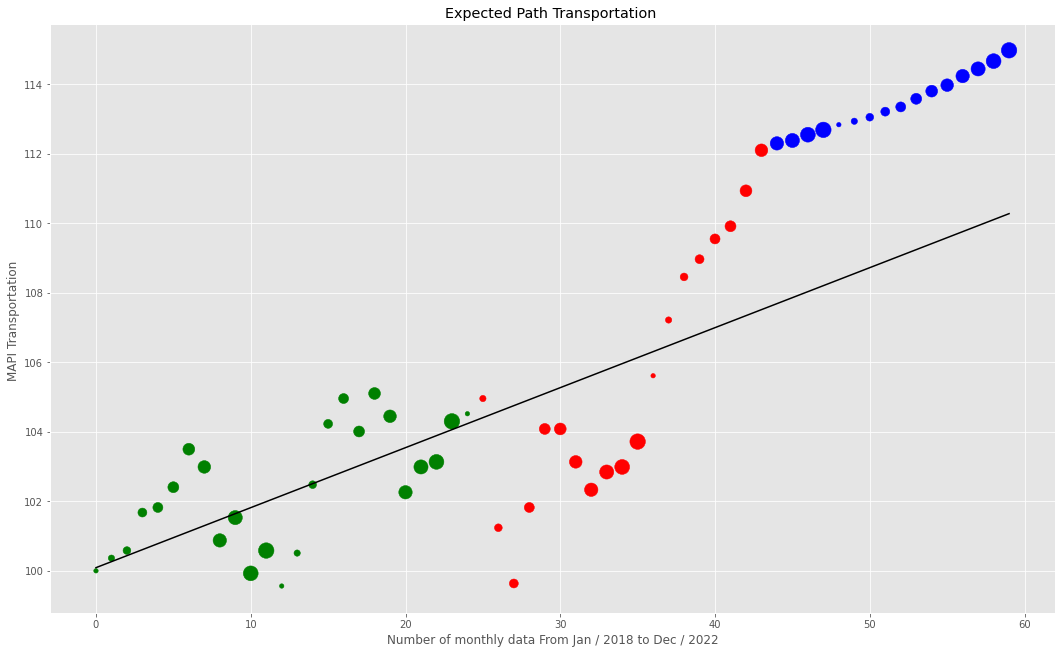

In [41]:
fig, ax = plt.subplots(figsize=(18, 10.84))

ax.scatter(x=rm2.Data,y=rm2.VALUE, s=rm2.month*20, marker='o', color = np.array(rm2["pa_col"]))
ax.plot(rm2.Data, rm2.Pred_r, linestyle='-', color='black')
plt.gca().set_title('Expected Path' + P_G_S)
plt.xlabel('Number of monthly data From Jan / 2018 to Dec / 2022')
plt.ylabel('MAPI' + P_G_S)

Text(0, 0.5, 'MAPI Transportation ')

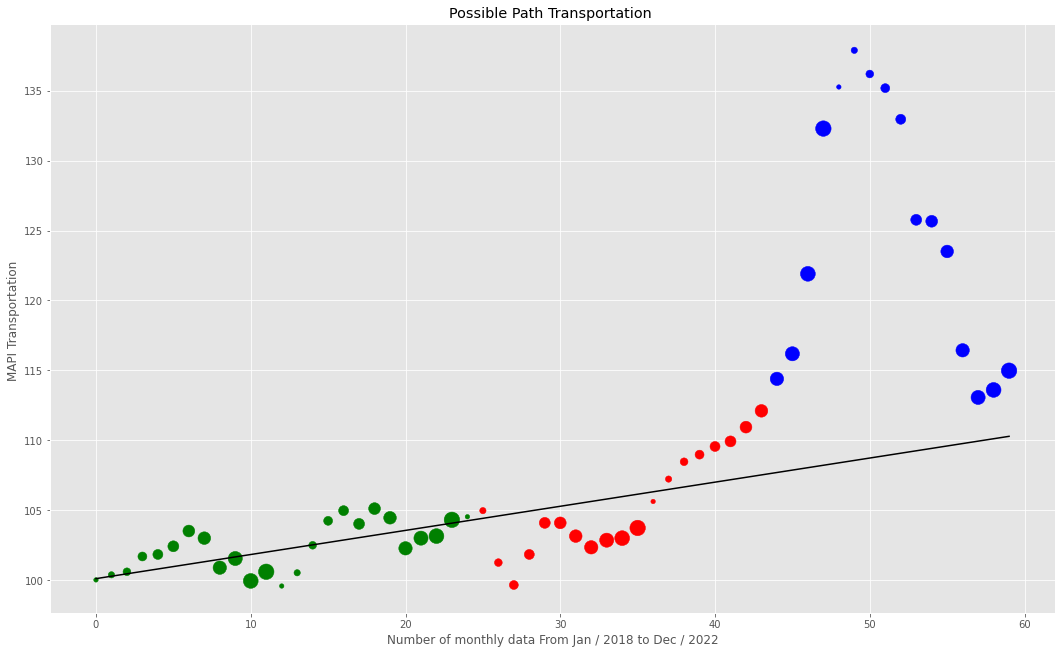

In [42]:
fig, ax = plt.subplots(figsize=(18, 10.84))

ax.scatter(x=rm3.Data,y=rm3.VALUE, s=rm3.month*20, marker='o', color = np.array(rm3["pa_col"]))
ax.plot(rm3.Data, rm3.Pred_r, linestyle='-', color='black')

plt.gca().set_title('Possible Path' + P_G_S)
plt.xlabel('Number of monthly data From Jan / 2018 to Dec / 2022')
plt.ylabel('MAPI' + P_G_S)